# About the dataset and the use case

The dataset that I have chosen contains reviews of the top 10 rated airlines in 2023, sourced from the Airline Quality website ().https://www.airlinequality.com

This project aims to analyse customer reviews from ten different airlines.

The reviews will be classified into three distinct sentiment classes: 'Positive,' 'Negative,' or 'Neutral.'

By implementing a model for sentiment analysis and classification, it can help airline companies gain valuable insights into their passenger experiences.




# Importing and downloading all necessary packages

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from gensim.models import Word2Vec
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Data Preparation

In [ ]:
# Load the dataset
file_path = 'airlines_reviews.csv'
dataset = pd.read_csv(file_path)

# Display any 5 random rows
dataset.sample(n=5)

In [3]:
# Display summary of DataFrame
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8100 entries, 0 to 8099
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Title                   8100 non-null   object
 1   Name                    8100 non-null   object
 2   Review Date             8100 non-null   object
 3   Airline                 8100 non-null   object
 4   Verified                8100 non-null   object
 5   Reviews                 8100 non-null   object
 6   Type of Traveller       8100 non-null   object
 7   Month Flown             8100 non-null   object
 8   Route                   8100 non-null   object
 9   Class                   8100 non-null   object
 10  Seat Comfort            8100 non-null   int64 
 11  Staff Service           8100 non-null   int64 
 12  Food & Beverages        8100 non-null   int64 
 13  Inflight Entertainment  8100 non-null   int64 
 14  Value For Money         8100 non-null   int64 
 15  Over

# 2. Exploratory Data Analysis (EDA)

In [4]:
# Checking for missing values
dataset.isnull().sum()

,0
Title,0
Name,0
Review Date,0
Airline,0
Verified,0
Reviews,0
Type of Traveller,0
Month Flown,0
Route,0
Class,0


In [5]:
# Checking for any duplicate rows in the dataset
duplicate_rows = dataset[dataset.duplicated()]
print(duplicate_rows.shape[0])

0


In [6]:
# Function to display distribution count
def plot_count_distribution(column_name, title, dataset):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column_name, data=dataset, order=dataset[column_name].value_counts().index)
    plt.title(title)
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.show()

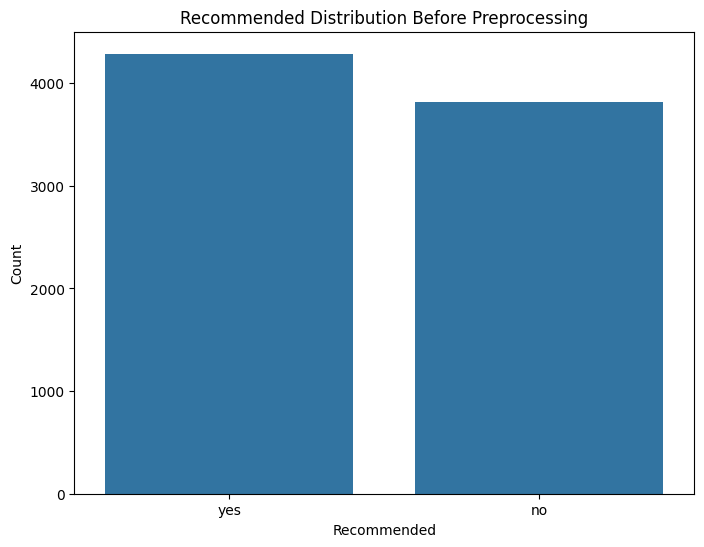

,count
Recommended,
yes,4287
no,3813


In [7]:
# Distribution count of 'Recommended' column
plot_count_distribution('Recommended', "Recommended Distribution Before Preprocessing", dataset)
dataset["Recommended"].value_counts()

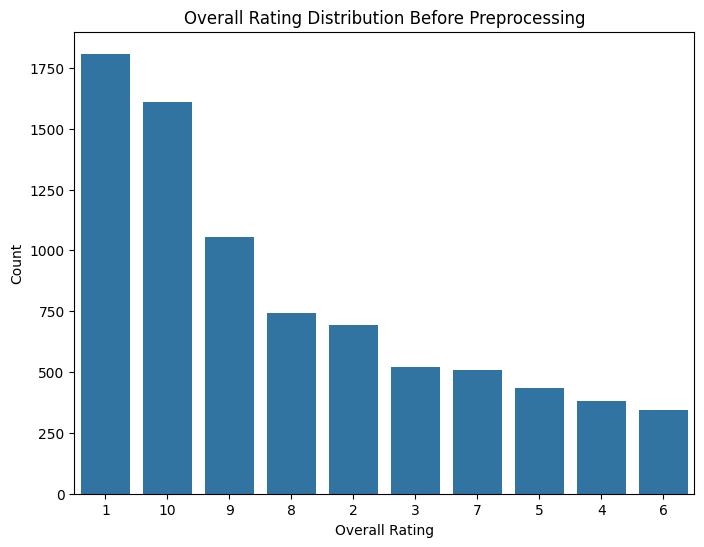

,count
Overall Rating,
1,1808
10,1610
9,1054
8,742
2,692
3,522
7,509
5,436
4,381


In [8]:
# Distribution count of 'Overall Rating' column
plot_count_distribution('Overall Rating', "Overall Rating Distribution Before Preprocessing", dataset)
dataset["Overall Rating"].value_counts()

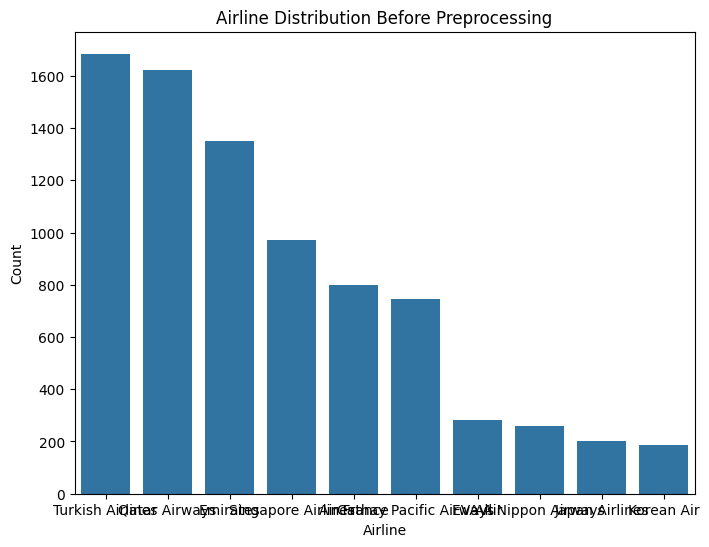

,count
Airline,
Turkish Airlines,1685
Qatar Airways,1624
Emirates,1350
Singapore Airlines,972
Air France,798
Cathay Pacific Airways,744
EVA Air,281
All Nippon Airways,258
Japan Airlines,201


In [9]:
# Distribution count of 'Airline' column
plot_count_distribution('Airline', "Airline Distribution Before Preprocessing", dataset)
dataset["Airline"].value_counts()

# 3. Data Preprocessing

## Creating Sentiment Labels

Define Sentiment Classes:

*   Positive: Overall Rating ≥ 7 and Recommended = yes.
*   Negative: Overall Rating ≤ 3 and Recommended = no.
*   Neutral: Any other Rating


In [10]:
# Mapping sentiment labels based on "Overall Rating" and "Recommended"
def classify_sentiment(row):
    if row["Overall Rating"] >= 7 and row["Recommended"].strip().lower() == "yes":
        return "Positive"
    elif row["Overall Rating"] <= 3 and row["Recommended"].strip().lower() == "no":
        return "Negative"
    else:
        return "Neutral"

# Create a new column for sentiment labels
dataset["Sentiment"] = dataset.apply(classify_sentiment, axis=1)

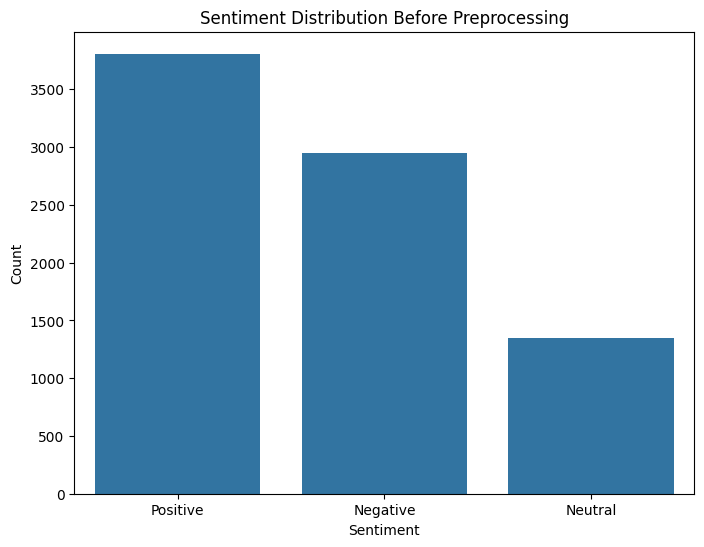

,count
Sentiment,
Positive,3808
Negative,2948
Neutral,1344


In [11]:
# Distribution count of 'Sentiment' column
plot_count_distribution('Sentiment', "Sentiment Distribution Before Preprocessing", dataset)
dataset["Sentiment"].value_counts()

In [12]:
# Encoding "Sentiment" column
le = LabelEncoder()
dataset['Encoded_Sentiment'] = le.fit_transform(dataset['Sentiment'])

# Checking the mapping for encoded sentiment labels
print("Label Mapping:")
for label, encoded_label in zip(le.classes_, range(len(le.classes_))):
    print(f"{label} -> {encoded_label}")

Label Mapping:
Negative -> 0
Neutral -> 1
Positive -> 2


In [13]:
# Display updated dataset to show the addition of "Sentiment" and  "Encoded_Sentiment" columns
dataset.sample(n=5)

,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended,Sentiment,Encoded_Sentiment
1155,always consistently good,Dom Grundy,2023-04-22,Qatar Airways,False,Flown with Qatar Airways to the UK a few tim...,Couple Leisure,April 2023,Brisbane to Manchester via Doha,Economy Class,3,5,5,5,5,10,yes,Positive,2
4328,"Onboard service great, as ever",Clive Thomas,2018-09-09,Japan Airlines,False,JL PY cabin LHR/HND departing 0930 on a Sund...,Business,August 2018,Delhi to Dallas via Tokyo,Premium Economy,4,5,1,5,4,9,yes,Positive,2
5379,you get to know their quirks,J Deakin,2019-07-05,Turkish Airlines,True,Manchester to Ercan via Istanbul. Check-in &...,Couple Leisure,July 2019,Montreal to Istanbul,Business Class,2,4,4,4,4,7,yes,Positive,2
1283,well managed flight with friendly staff,P Burtele,2022-10-03,Qatar Airways,True,Overall very well managed flight with friend...,Business,October 2022,Jakarta to Doha,Economy Class,3,4,4,5,3,8,yes,Positive,2
3327,Very cheap food,J Jones,2019-10-04,Emirates,True,Trivandrum to New York via Dubai. Very cheap ...,Family Leisure,September 2019,Paris to Brisbane via Dubai,Economy Class,1,1,2,3,3,2,no,Negative,0


## Text Preprocessing

In [14]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+", "", text)   # Remove URLs
    text = re.sub(r"<.*?>", "", text)            # Remove HTML tags
    text = re.sub(r"[^\x00-\x7F]+", "", text)    # Remove emojis
    text = re.sub(r"[^a-zA-Z\s]", "", text)      # Remove special characters, numbers, and punctuations
    text = text.lower()                          # Convert all text to lowercase
    text = re.sub(r"\s+", " ", text).strip()     # Remove extra whitespaces
    tokens = word_tokenize(text)                 # Tokenize words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] # Remove stopwords and lemmatize
    return " ".join(tokens)

# Preprocess reviews
dataset["Cleaned_Reviews"] = dataset["Reviews"].apply(preprocess_text)
dataset["Tokenized_Reviews"] = dataset["Cleaned_Reviews"].apply(word_tokenize)

# Display the updated datset
dataset.sample(n=5)

,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,...,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended,Sentiment,Encoded_Sentiment,Cleaned_Reviews,Tokenized_Reviews
469,good for economy class,Elaine Loh,2019-06-03,Singapore Airlines,True,Singapore to Amsterdam. I am not sure I can ...,Solo Leisure,June 2019,Christchurch to Singapore,Economy Class,...,5,5,3,5,8,yes,Positive,2,singapore amsterdam sure rave service flight r...,"[singapore, amsterdam, sure, rave, service, fl..."
5132,Not happy with my travel experience,Hafsa Kausar,2020-08-13,Turkish Airlines,False,Traveled with Turkish airlines 2 years ago wh...,Family Leisure,August 2020,Barcelona to Bangkok via Istanbul,Economy Class,...,4,4,4,2,4,no,Neutral,1,traveled turkish airline year ago whilst going...,"[traveled, turkish, airline, year, ago, whilst..."
2017,On arrival there was no stroller,H Alhamas,2018-10-21,Qatar Airways,True,Montreal to Doha. On aircraft the staff took...,Family Leisure,October 2018,Perth to Doha,Economy Class,...,5,4,3,4,5,yes,Neutral,1,montreal doha aircraft staff took baby strolle...,"[montreal, doha, aircraft, staff, took, baby, ..."
6633,A brilliant flight,P Rogers,2018-06-13,Air France,True,"Paris to Johannesburg. A brilliant flight, s...",Solo Leisure,June 2018,Los Angeles to Paris,Business Class,...,1,1,5,4,9,yes,Positive,2,paris johannesburg brilliant flight super atte...,"[paris, johannesburg, brilliant, flight, super..."
7967,appreciate all their effort,John Kau,2019-09-27,Korean Air,True,I was flying Korean Air from Jeju to Gimpo. ...,Family Leisure,August 2019,Jeju to Seoul Gimpo,Economy Class,...,5,2,4,4,10,yes,Positive,2,flying korean air jeju gimpo parent law catchi...,"[flying, korean, air, jeju, gimpo, parent, law..."


## Word Frequency Analysis

Top 20 Most Common Words:
[('flight', 16956), ('seat', 7378), ('airline', 6944), ('service', 6856), ('time', 5533), ('hour', 4469), ('food', 4379), ('good', 4066), ('crew', 3959), ('staff', 3710), ('class', 3599), ('one', 3466), ('cabin', 3283), ('business', 3082), ('airport', 3028), ('meal', 3027), ('via', 2977), ('u', 2929), ('would', 2865), ('passenger', 2659)]


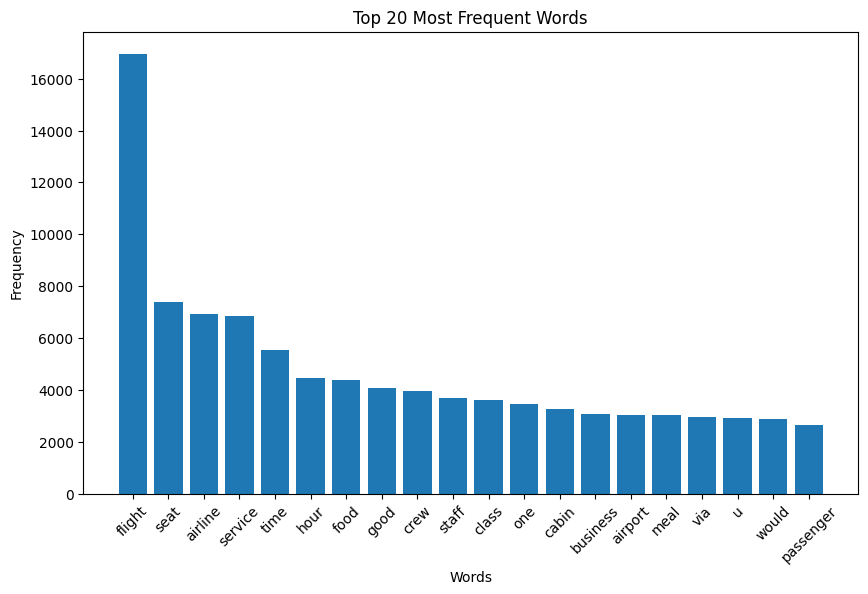

In [15]:
# Combine all cleaned reviews into a single string
all_words = " ".join(dataset["Cleaned_Reviews"].tolist()).split()

# Count word frequencies
word_freq = Counter(all_words).most_common(20)
print("Top 20 Most Common Words:")
print(word_freq)

# Distribution of count word frequencies
plt.figure(figsize=(10, 6))
most_common_words, counts = zip(*word_freq)
plt.bar(most_common_words, counts)
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

## Data Cleaning

In [16]:
# Drop irrelevant columns based on domain knowledge initially
columns_to_drop = ["Title", "Name", "Review Date", "Verified", "Type of Traveller", "Month Flown", "Overall Rating", "Recommended"]
dataset.drop(columns=columns_to_drop, axis=1, inplace=True, errors="ignore")

# Display updated dataset
dataset.sample(n=5)

,Airline,Reviews,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Sentiment,Encoded_Sentiment,Cleaned_Reviews,Tokenized_Reviews
1168,Qatar Airways,Flew Barcelona to Goa via Doha. We booked se...,Barcelona to Goa via Doha,Economy Class,5,5,4,4,4,Positive,2,flew barcelona goa via doha booked seat plane ...,"[flew, barcelona, goa, via, doha, booked, seat..."
8089,Korean Air,Hong Kong to Seoul on Boeing 747-8I. General...,HKG to ICN,Economy Class,5,5,4,4,4,Positive,2,hong kong seoul boeing generally young cabin c...,"[hong, kong, seoul, boeing, generally, young, ..."
5160,Turkish Airlines,London to Cape Town via Istanbul. I have nev...,Bogota to Istanbul,Economy Class,3,1,1,4,1,Negative,0,london cape town via istanbul never worse expe...,"[london, cape, town, via, istanbul, never, wor..."
7865,EVA Air,New York to Taipei. There were no major prob...,New York to Taipei,Economy Class,5,5,5,3,4,Positive,2,new york taipei major problem one stewardess b...,"[new, york, taipei, major, problem, one, stewa..."
4058,Emirates,Rome to Bangkok via Dubai. A wonderful journe...,JFK to CAN via DXB,Economy Class,4,5,4,5,3,Neutral,1,rome bangkok via dubai wonderful journey emira...,"[rome, bangkok, via, dubai, wonderful, journey..."


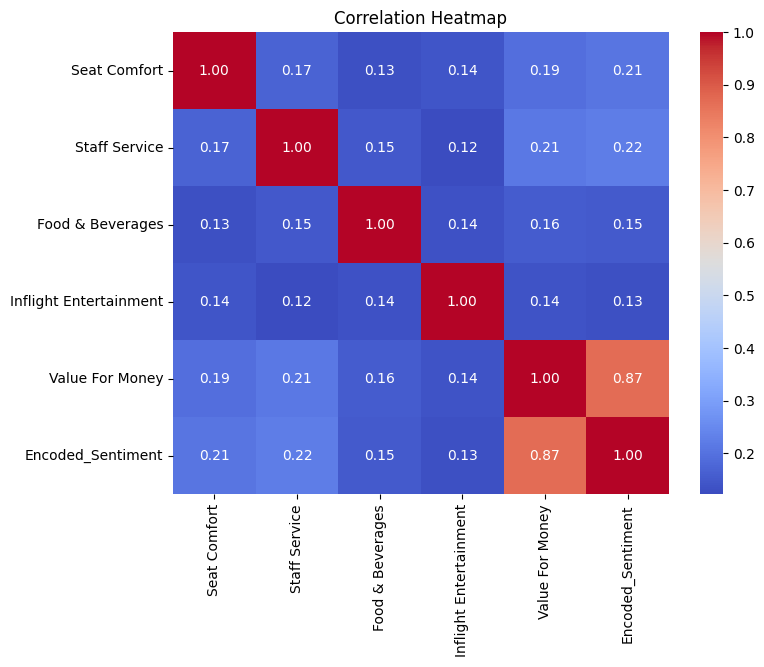

In [17]:
# Checking correlation with sentiment labels
correlation_matrix = dataset[["Seat Comfort", "Staff Service", "Food & Beverages", "Inflight Entertainment", "Value For Money", "Encoded_Sentiment"]].corr()

# Heatmap to visualise the correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

In [18]:
# Drop weakly correlated features
features_to_drop = ["Seat Comfort", "Food & Beverages", "Inflight Entertainment"]
dataset = dataset.drop(columns=features_to_drop, axis=1)

# Display updated dataset
dataset.sample(n=5)

,Airline,Reviews,Route,Class,Staff Service,Value For Money,Sentiment,Encoded_Sentiment,Cleaned_Reviews,Tokenized_Reviews
789,Singapore Airlines,Singapore to Colombo with Singapore Airlines....,Munich to Singapore,Economy Class,5,3,Negative,0,singapore colombo singapore airline check full...,"[singapore, colombo, singapore, airline, check..."
5105,Turkish Airlines,Flew with Turkish Airlines during Covid with ...,Moscow to Chicago via Istanbul,Economy Class,5,2,Negative,0,flew turkish airline covid two child social di...,"[flew, turkish, airline, covid, two, child, so..."
3783,Emirates,I had a flight from Bangkok to Paris (France...,Athens to Dubai,Economy Class,1,1,Negative,0,flight bangkok paris france via dubai transit ...,"[flight, bangkok, paris, france, via, dubai, t..."
700,Singapore Airlines,Bangkok to Singapore. This sector was the se...,Surabaya to Singapore,Economy Class,5,4,Positive,2,bangkok singapore sector second sector flight ...,"[bangkok, singapore, sector, second, sector, f..."
7515,Cathay Pacific Airways,Flew Mumbai to Da Nang (or tried to) via Hon...,Mumbai to Danang via Hong Kong,Business Class,3,1,Negative,0,flew mumbai da nang tried via hong kong wife m...,"[flew, mumbai, da, nang, tried, via, hong, kon..."


## Feature Engineering

In [19]:
# Train Word2Vec Model
w2v_model = Word2Vec(
    sentences=dataset['Tokenized_Reviews'],
    vector_size=100,  # Dimensionality of embeddings
    window=5,         # Context window size
    min_count=1,      # Minimum word frequency
    workers=4         # Number of threads
)

# Display updated dataset
dataset.sample(n=5)

,Airline,Reviews,Route,Class,Staff Service,Value For Money,Sentiment,Encoded_Sentiment,Cleaned_Reviews,Tokenized_Reviews
7565,Cathay Pacific Airways,Flew Cathay Pacific from Hong Kong to London...,HKG to LHR,Premium Economy,5,2,Positive,2,flew cathay pacific hong kong london heathrow ...,"[flew, cathay, pacific, hong, kong, london, he..."
7128,Cathay Pacific Airways,Melbourne to Tokyo via Hong Kong. Every time...,Melbourne to Tokyo via Hong Kong,Economy Class,4,1,Negative,0,melbourne tokyo via hong kong every time ive f...,"[melbourne, tokyo, via, hong, kong, every, tim..."
7105,Cathay Pacific Airways,Sydney to Dubai via Hong Kong. At my Sydney b...,Sydney to Dubai via Hong Kong,Economy Class,5,2,Neutral,1,sydney dubai via hong kong sydney bag drop for...,"[sydney, dubai, via, hong, kong, sydney, bag, ..."
5197,Turkish Airlines,Cairo to Istanbul. A high quality of hardwar...,Milano to Hanoi via Istanbul,Economy Class,4,4,Neutral,1,cairo istanbul high quality hardware cabin cat...,"[cairo, istanbul, high, quality, hardware, cab..."
7919,Korean Air,No courtesy to passengers. Flight was delaye...,Honolulu to Manila via Seoul,Economy Class,4,1,Negative,0,courtesy passenger flight delayed hour missed ...,"[courtesy, passenger, flight, delayed, hour, m..."


In [20]:
# Generate sentence embeddings
def get_sentence_embedding(tokens, model):
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Generate embeddings for all reviews
X_word2vec = np.array([get_sentence_embedding(tokens, w2v_model) for tokens in dataset['Tokenized_Reviews']])

In [21]:
# TF-IDF Vectorization with n-grams
tfv = TfidfVectorizer(min_df=3,
                      max_features=5000,
                      ngram_range=(1, 3), # Considers unigrams, bigrams, and trigrams (1 to 3 consecutive words) for feature extraction, capturing richer context.
                      stop_words='english')
X_tfidf = tfv.fit_transform(dataset['Cleaned_Reviews'])

In [22]:
# Combine TF-IDF and Word2Vec
scaler = StandardScaler()
X_word2vec_scaled = scaler.fit_transform(X_word2vec)
X_combined = hstack([X_tfidf, X_word2vec_scaled])

## Cleaned Dataset

In [24]:
# Save cleaned dataset for future use
dataset.to_csv("cleaned_airline_reviews.csv", index=False)

# 4. Train-test Split for Unbalanced Dataset

In [25]:
X_train_unbalanced, X_test_unbalanced, Y_train_unbalanced, Y_test_unbalanced = train_test_split(
    X_combined, dataset['Encoded_Sentiment'], test_size=0.25, random_state=5, stratify=dataset['Encoded_Sentiment'])

# 5. Balancing the Dataset

In [26]:
# Check the class distribution for 'Encoded_Sentiment'
pd.Series(Y_train_unbalanced).value_counts()

,count
Encoded_Sentiment,
2,2856
0,2211
1,1008


In [27]:
# SMOTE for balanced data
smote = SMOTE(random_state=42)
X_train_balanced, Y_train_balanced = smote.fit_resample(X_train_unbalanced, Y_train_unbalanced)

# Check the new distribution or 'Encoded_Sentiment'
pd.Series(Y_train_balanced).value_counts()

,count
Encoded_Sentiment,
2,2856
1,2856
0,2856


# 6. Training on Unbalanced Data

This is to establish a baseline performance and provide a benchmark for the models.

In [28]:
# Function for training and evaluating models
def train_and_evaluate_model(model, X_train, Y_train, X_test, Y_test, model_name, labels):
    model.fit(X_train, Y_train)         # Training
    predictions = model.predict(X_test) # Prediction

    # Metrics
    print(f"{model_name} Accuracy: {accuracy_score(Y_test, predictions)*100:.2f}%")
    print()

    print(f"Cross-Validation Report: {np.mean(cross_val_score(model, X_train, Y_train, cv=5))}")
    print()

    print(f"{model_name} Classification Report:")
    print(classification_report(Y_test, predictions))
    print()

    cm = confusion_matrix(Y_test, predictions, labels=range(len(labels)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## Naive Bayes (GaussianNB) on Unbalanced Data

Naive Bayes (Unbalanced - GaussianNB) Accuracy: 70.81%

Cross-Validation Report: 0.6839506172839507

Naive Bayes (Unbalanced - GaussianNB) Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       737
           1       0.31      0.37      0.34       336
           2       0.83      0.77      0.80       952

    accuracy                           0.71      2025
   macro avg       0.64      0.64      0.64      2025
weighted avg       0.72      0.71      0.71      2025




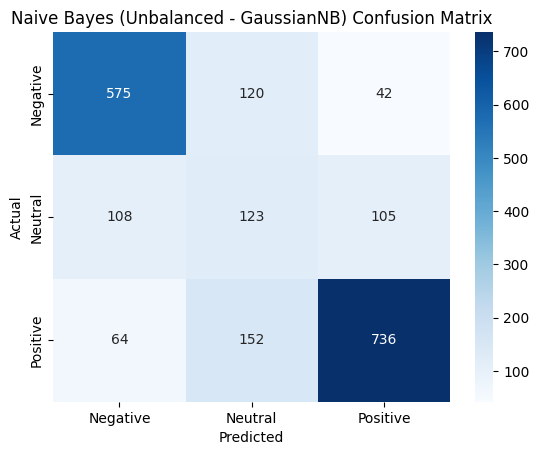

In [29]:
train_and_evaluate_model(GaussianNB(), X_train_unbalanced.toarray(), Y_train_unbalanced, X_test_unbalanced.toarray(), Y_test_unbalanced, "Naive Bayes (Unbalanced - GaussianNB)", le.classes_)

### **Summary of Observations**

1. Class Imbalance Effect

  The Neutral class is the hardest to predict. This might be because the model is biased toward the more frequent classes (Negative and Positive).


2. Poor Neutral Class Performance

  Precision (0.31), recall (0.37), and F1-score (0.34) indicate that the model struggles with Neutral instances.


3. Overall Performance

  The model performs decently overall (71% accuracy).



## Logistic Regression on Unbalanced Data

Logistic Regression (Unbalanced) Accuracy: 79.46%

Cross-Validation Report: 0.7940740740740742

Logistic Regression (Unbalanced) Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       737
           1       0.46      0.25      0.32       336
           2       0.85      0.92      0.89       952

    accuracy                           0.79      2025
   macro avg       0.70      0.68      0.68      2025
weighted avg       0.77      0.79      0.77      2025




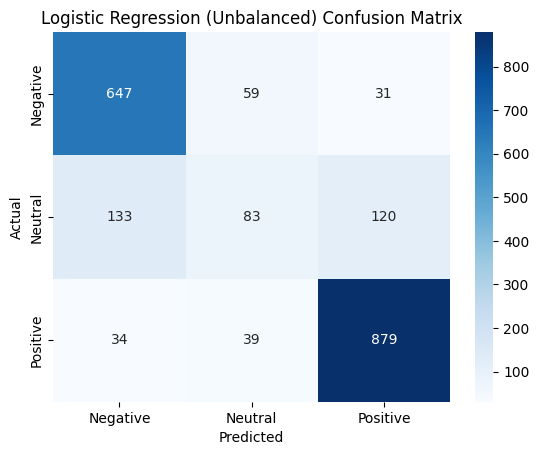

In [30]:
train_and_evaluate_model(LogisticRegression(max_iter=1000), X_train_unbalanced, Y_train_unbalanced, X_test_unbalanced, Y_test_unbalanced, "Logistic Regression (Unbalanced)", le.classes_)

### **Summary of Observations**

1. Class Imbalance Effect
  
  The Neutral class is the hardest to predict. This might be because the model is biased toward the more frequent classes (Negative and Positive).


2. Poor Neutral Class Performance
  
  Precision (0.46), recall (0.25), and F1-score (0.32) indicate that the model struggles with Neutral instances.


3. Overall Performance
  
  The model performs decently overall (79% accuracy).


## SVM on Unbalanced Data

SVM (Unbalanced) Accuracy: 80.25%

Cross-Validation Report: 0.7896296296296297

SVM (Unbalanced) Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       737
           1       0.46      0.29      0.36       336
           2       0.88      0.92      0.90       952

    accuracy                           0.80      2025
   macro avg       0.71      0.70      0.70      2025
weighted avg       0.78      0.80      0.79      2025




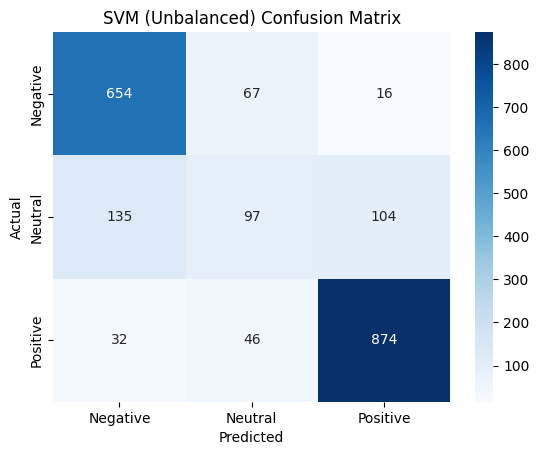

In [31]:
train_and_evaluate_model(SVC(kernel='linear'), X_train_unbalanced, Y_train_unbalanced, X_test_unbalanced, Y_test_unbalanced, "SVM (Unbalanced)", le.classes_)

### **Summary of Observations**

1. Class Imbalance Effect

  The Neutral class is the hardest to predict. This might be because the model is biased toward the more frequent classes (Negative and Positive).


2. Poor Neutral Class Performance
  
  Precision (0.46), recall (0.29), and F1-score (0.36) indicate that the model struggles with Neutral instances.


3. Overall Performance

  The model performs well overall, achieving an accuracy of 80.25%.

# 7. Training on Balanced Data

## Naive Bayes (GaussianNB) on Balanced Data

Naive Bayes (Balanced - GaussianNB) Accuracy: 71.41%

Cross-Validation Report: 0.7976297664711

Naive Bayes (Balanced - GaussianNB) Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       737
           1       0.33      0.35      0.34       336
           2       0.82      0.80      0.81       952

    accuracy                           0.71      2025
   macro avg       0.64      0.64      0.64      2025
weighted avg       0.72      0.71      0.72      2025




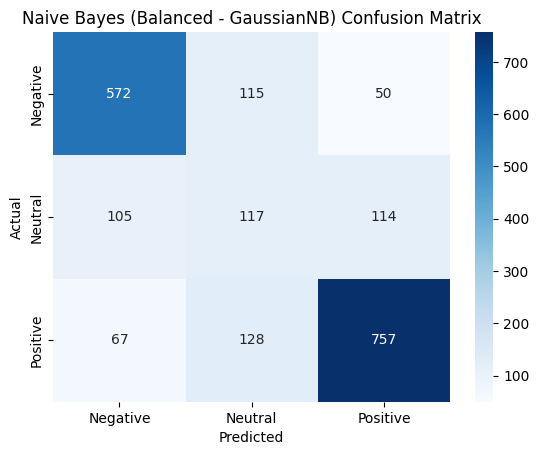

In [32]:
train_and_evaluate_model(GaussianNB(), X_train_balanced.toarray(), Y_train_balanced, X_test_unbalanced.toarray(), Y_test_unbalanced, "Naive Bayes (Balanced - GaussianNB)", le.classes_)

### **Improvement after balancing dataset**
* **Accuracy:** Slight improvement of 71.41% from 70.81%.

* **Cross-Validation:** Improved significantly to 0.7976, indicating better model generalization across folds.

* **Neutral Class:** Slight improvement in precision (0.33 vs 0.31 previously), but recall dropped slightly to 0.35. Overall, the class remains challenging.

* **Positive Class:** Improved recall (0.80, up from 0.77) and maintained strong performance with an F1-score of 0.81.

* **Negative Class:** Consistent results with precision and recall holding steady around 0.77–0.78.

## Logistic Regression on Balanced Data

Logistic Regression (Balanced) Accuracy: 77.88%

Cross-Validation Report: 0.8341569479326532

Logistic Regression (Balanced) Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       737
           1       0.42      0.49      0.45       336
           2       0.90      0.86      0.88       952

    accuracy                           0.78      2025
   macro avg       0.71      0.72      0.72      2025
weighted avg       0.79      0.78      0.78      2025




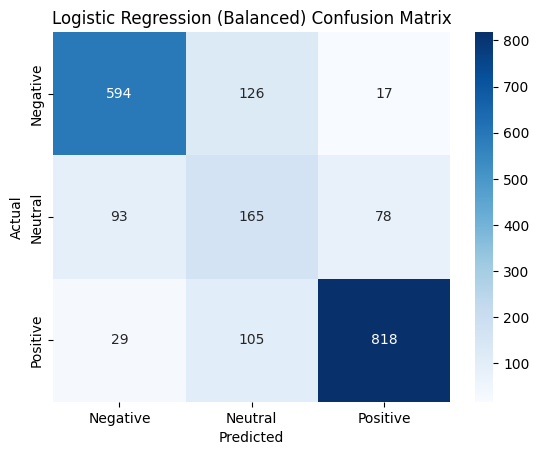

In [33]:
train_and_evaluate_model(LogisticRegression(max_iter=1000), X_train_balanced, Y_train_balanced, X_test_unbalanced, Y_test_unbalanced, "Logistic Regression (Balanced)", le.classes_)

### **Improvement after balancing dataset**
* **Accuracy:** Decreased slightly to 77.88% from 79.46%.

* **Cross-Validation:** Improved significantly to 0.834, indicating better model generalization across folds.

* **Neutral Class:** Significant improvement in recall (0.49, up from 0.25) and a better F1-score (0.45). However, precision remains low at 0.42.

* **Positive Class:** Maintained strong performance with high precision (0.90) and recall (0.86), ensuring robust predictions overall.

* **Negative Class:** Consistent performance with a minor decrease in recall (0.81, down from 0.88).

## SVM on Balanced Data

SVM (Balanced) Accuracy: 77.73%

Cross-Validation Report: 0.8638014878331054

SVM (Balanced) Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       737
           1       0.41      0.44      0.42       336
           2       0.90      0.87      0.88       952

    accuracy                           0.78      2025
   macro avg       0.70      0.71      0.71      2025
weighted avg       0.78      0.78      0.78      2025




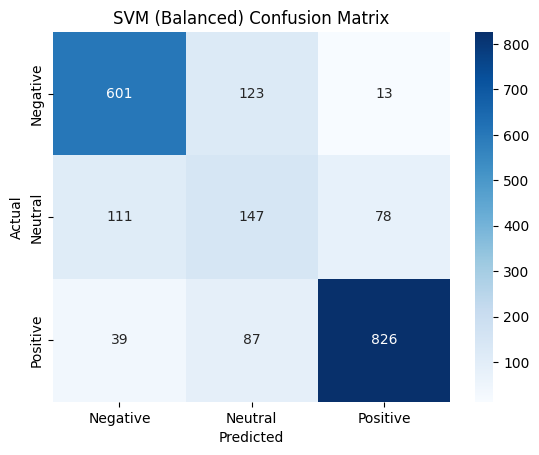

In [34]:
train_and_evaluate_model(SVC(kernel='linear'), X_train_balanced, Y_train_balanced, X_test_unbalanced, Y_test_unbalanced, "SVM (Balanced)", le.classes_)

### **Improvement after balancing dataset**
* **Accuracy:** Decreased slightly to 77.73% from 80.25%.

* **Cross-Validation:** Improved significantly to 0.8638, indicating better model generalization across folds.

* **Neutral Class:** Significant improvement in recall (0.44, up from 0.29) and a better F1-score (0.42). However, precision remains relatively low at 0.41.

* P**ositive Class:** Maintained strong performance with precision at 0.90 and recall at 0.87, ensuring robust predictions overall.

* **Negative Class:** Consistent performance with a slight drop in recall to 0.82 (down from 0.89), but precision remains solid at 0.80.


# 8. Hyper-parameter Tuning

## Hyper-parameter Tuning for Naive Bayes (GaussianNB)

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters for GaussianNB: {'var_smoothing': 1e-05}

Naive Bayes (Tuned) Accuracy: 73.78%

Cross-Validation Report: 0.8029970552593559

Naive Bayes (Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       737
           1       0.36      0.35      0.36       336
           2       0.83      0.84      0.83       952

    accuracy                           0.74      2025
   macro avg       0.66      0.66      0.66      2025
weighted avg       0.73      0.74      0.74      2025




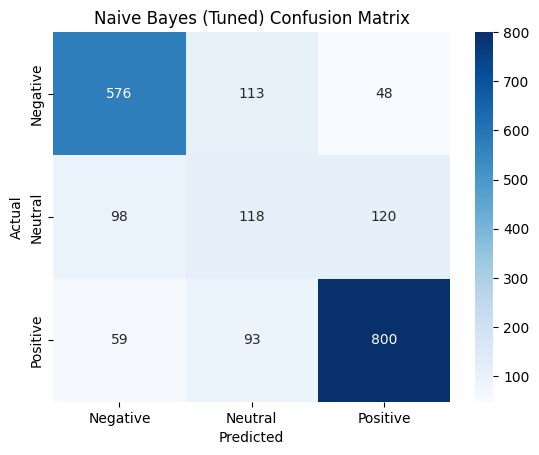

In [35]:
# Define parameter grid for GaussianNB
gnb_param_grid = {
    'var_smoothing': np.logspace(0, -9, num=10)  # Test a range of small values
}

# GridSearchCV for GaussianNB
gnb_grid = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=gnb_param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Perform grid search
gnb_grid.fit(X_train_balanced.toarray(), Y_train_balanced)
print()

# Evaluate the best estimator
print("Best Parameters for GaussianNB:", gnb_grid.best_params_)
print()
train_and_evaluate_model(
    gnb_grid.best_estimator_,
    X_train_balanced.toarray(), Y_train_balanced, X_test_unbalanced.toarray(), Y_test_unbalanced,
    "Naive Bayes (Tuned)", le.classes_
)

### **Improvement after tuning**
* **Accuracy:** Improved from 71.41% (Balanced) to 73.78% (Tuned).

* **Cross-Validation:** Improved further to 0.803 (Tuned) compared to 0.7976 (Balanced), indicating better generalization.

* **Neutral Class:**
  
  * Precision increased slightly to 0.36 (Tuned) from 0.33 (Balanced).
  * Recall remained stable at 0.35, leading to an improved F1-score of 0.36 (up from 0.34).

* **Positive Class:**
  * Precision improved to 0.83 (Tuned) vs 0.82 (Balanced).
  * Recall improved significantly to 0.84 (Tuned) from 0.80 (Balanced), resulting in an F1-score of 0.83.

* **Negative Class:** Minor improvement in precision and recall, 0.79 and 0.78.

## Hyper-parameter Tuning for Logistic Regression

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/u


Best Parameters for Logistic Regression: {'C': 100, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}

Logistic Regression (Tuned) Accuracy: 76.54%

Cross-Validation Report: 0.8994004254649564

Logistic Regression (Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       737
           1       0.38      0.37      0.37       336
           2       0.87      0.87      0.87       952

    accuracy                           0.77      2025
   macro avg       0.68      0.68      0.68      2025
weighted avg       0.76      0.77      0.76      2025




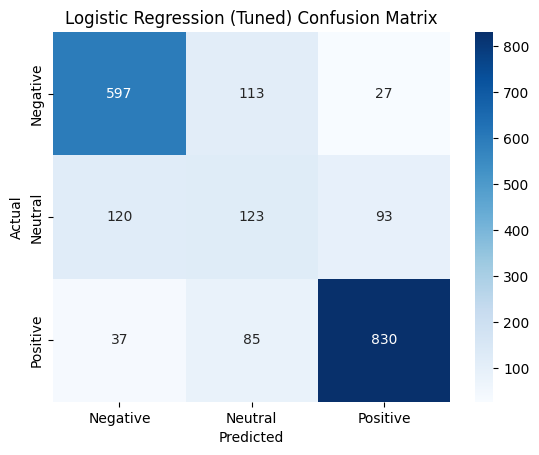

In [36]:
# Define parameter grid for Logistic Regression
lr_param_grid = {
    'C': [0.01, 0.1, 1.0, 10, 100],     # Regularization strength
    'penalty': ['l1', 'l2'],            # Regularization type
    'solver': ['liblinear', 'lbfgs'],   # Solvers compatible with l1/l2 penalties
    'max_iter': [500, 1000]             # Iteration limits
}

# GridSearchCV for Logistic Regression
lr_grid = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=lr_param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Perform grid search
lr_grid.fit(X_train_balanced, Y_train_balanced)
print()

# Evaluate the best estimator
print("Best Parameters for Logistic Regression:", lr_grid.best_params_)
print()
train_and_evaluate_model(
    lr_grid.best_estimator_,
    X_train_balanced, Y_train_balanced, X_test_unbalanced, Y_test_unbalanced,
    "Logistic Regression (Tuned)", le.classes_
)

### **Improvement after tuning**
* **Accuracy:** Decreased slightly to 76.54% (Tuned) from 77.88% (Balanced).

* **Cross-Validation:** Improved significantly to 0.8994 (Tuned) from 0.834 (Balanced), indicating stronger model generalization across folds.

* **Neutral Class:**
  * Precision improved slightly to 0.38 (Tuned) from 0.42 (Balanced).
  * Recall dropped to 0.37 (Tuned) from 0.49 (Balanced).
  * F1-score fell to 0.37 (Tuned) from 0.45 (Balanced), showing a slight decline in Neutral class performance.

* **Positive Class:**
  * Precision improved to 0.87 (Tuned) from 0.90 (Balanced).
  * Recall remained consistent at 0.87 (Tuned), resulting in a stable F1-score of 0.87.

* **Negative Class:** Precision remained at 0.79, while recall stayed steady at 0.81.

## Hyper-parameter Tuning for SVM

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters for SVM: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}

SVM (Tuned) Accuracy: 74.91%

Cross-Validation Report: 0.8962479249557743

SVM (Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       737
           1       0.34      0.32      0.33       336
           2       0.87      0.86      0.86       952

    accuracy                           0.75      2025
   macro avg       0.66      0.66      0.66      2025
weighted avg       0.75      0.75      0.75      2025




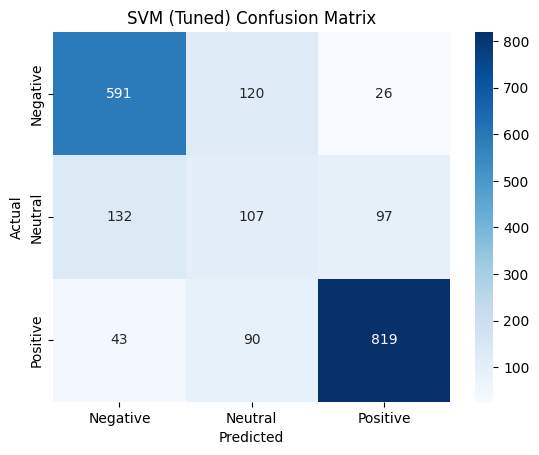

In [38]:
# Define parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],          # Regularization parameter
    'kernel': ['linear', 'rbf'],     # Linear or Radial Basis Function kernel
    'gamma': ['scale', 'auto'],      # Kernel coefficient for 'rbf'
}

# GridSearchCV for SVM
svm_grid = GridSearchCV(
    estimator=SVC(),
    param_grid=svm_param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Perform grid search
svm_grid.fit(X_train_balanced, Y_train_balanced)
print()

# Evaluate the best estimator
print("Best Parameters for SVM:", svm_grid.best_params_)
print()
train_and_evaluate_model(
    svm_grid.best_estimator_,
    X_train_balanced, Y_train_balanced, X_test_unbalanced, Y_test_unbalanced,
    "SVM (Tuned)", le.classes_
)

### **Improvement after tuning**

* **Accuracy:** Decreased slightly to 74.91% from 77.73% (Balanced) and 80.25% (Unbalanced).

* **Cross-Validation:** Improved significantly to 0.8962 from 0.8638 (Balanced), indicating better generalization.

* **Neutral Class:**
  * Precision: Slight decrease to 0.34 from 0.41 (Balanced).
  * Recall: Decreased to 0.32 from 0.44 (Balanced).
  * F1-Score: Dropped to 0.33 from 0.42 (Balanced), showing weaker performance on Neutral instances.

* **Positive Class:** Maintained strong performance with precision = 0.87 and recall = 0.86, leading to an F1-score of 0.86.

* **Negative Class:** Precision decreased slightly to 0.80 (from 0.83), but recall held steady at 0.82.

# 9. Summary of Performance Metrics for All Models

**Model Comparison Across All Classes**

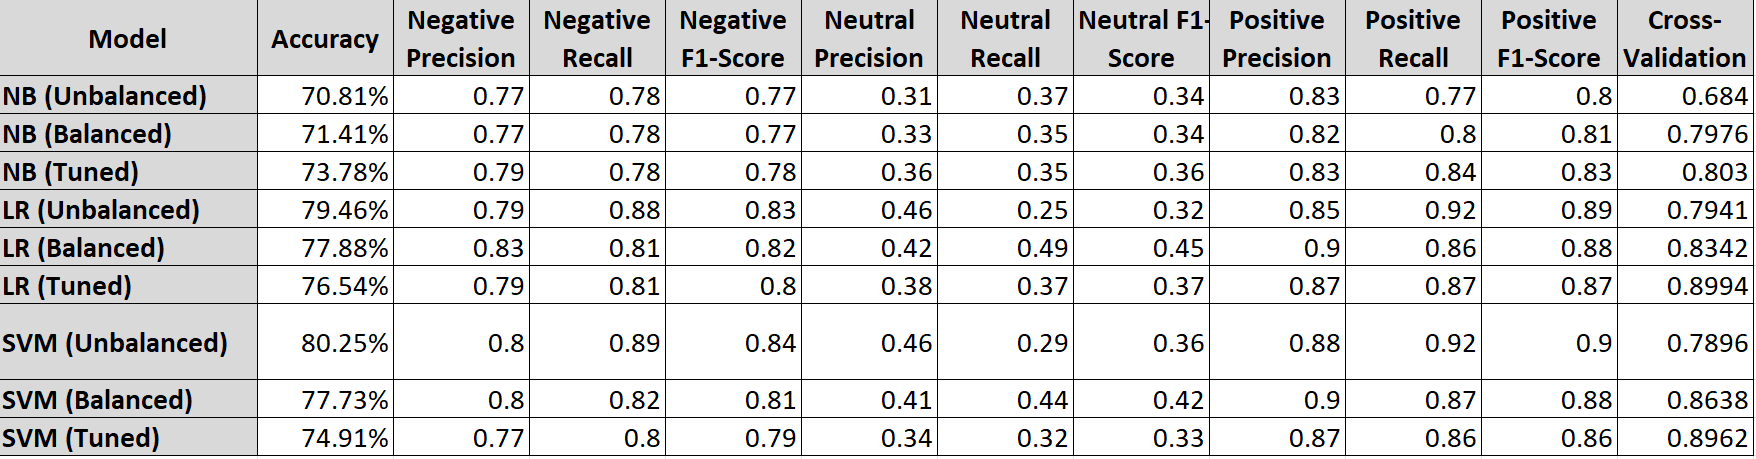

**Comparative Confusion Matrix Summary**

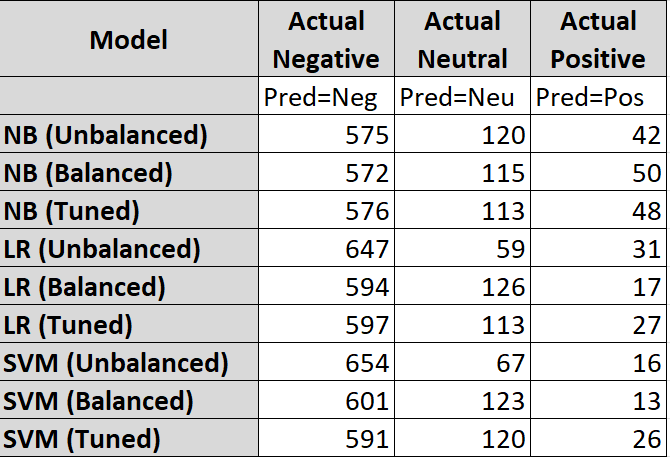

# 10. Model Deployment

### **Classification Model Chosen: Logistic Regression (Balanced)**

**Reason:**

This is because it provided the best overall balance in accurately predicting Negative, Neutral, and Positive classes.

This balance is crucial in a multiclass classification task, as misclassifying one class, especially the Neutral class, can significantly impact the interpretation of results.

**Challenges with Other Models:**

Both Naive Bayes and SVM struggled with capturing the complexities of the Neutral class, often overemphasizing either Negative or Positive sentiment.

**Importance of Classifying Neutral Reviews Accurately:**


Neutral reviews are important in sentiment analysis as they represent nuanced opinions that are neither positive nor negative.

Misclassifying these reviews can distort the overall sentiment distribution and lead to incorrect business decisions.


Logistic Regression’s ability to handle these reviews accurately reflects its robustness in multiclass scenarios.

## Saving all the necessary models

In [40]:
import joblib

joblib.dump(lr_grid.best_estimator_, "logistic_regression_balanced.pkl")

joblib.dump(tfv, "tfidf_vectorizer.pkl")

w2v_model.save("word2vec_model.bin")

joblib.dump(scaler, "scaler.pkl")

joblib.dump(le, "label_encoder.pkl")

print("All models has been saved successfully!")

All models has been saved successfully!


## Prediction Function

In [41]:
# Load the previously saved artifacts
lr_model = joblib.load("logistic_regression_balanced.pkl")
tfv = joblib.load("tfidf_vectorizer.pkl")
scaler = joblib.load("scaler.pkl")
w2v_model = Word2Vec.load("word2vec_model.bin")
le = joblib.load("label_encoder.pkl")

# Preprocessing functions
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^\x00-\x7F]+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

def get_sentence_embedding(tokens, model):
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(model.vector_size)

In [42]:
def pred(review):
    # Preprocess the review
    tokens = preprocess_text(review)
    cleaned_text = " ".join(tokens)

    # Generate TF-IDF features
    tfidf_features = tfv.transform([cleaned_text])

    # Generate Word2Vec features
    w2v_features = np.array([get_sentence_embedding(tokens, w2v_model)])
    w2v_scaled = scaler.transform(w2v_features)

    # Combine features
    combined_features = hstack([tfidf_features, w2v_scaled])

    # Predict sentiment
    prediction = lr_model.predict(combined_features)

    # Decode sentiment label
    predicted_label = le.inverse_transform(prediction)
    return predicted_label[0]

## Testing Prediction Function

In [53]:
reviews = [
    "I had high hopes for this airline, but it turned out to be a nightmare. My seat was broken, and the staff said there was nothing they could do. The flight was late, and there was no inflight entertainment. I asked for water, and it took them over 30 minutes to bring it. Definitely not worth the money.",
    "  Denpasar to Paris via Doha. I lost my mobile phone, I left it in the aircraft when it landed at DOH. The connection time at DOH was less than 40 minutes, and the gate agent for the flight from CDG to DOH assured us that the mobile would be listed on Qatar Airways online system within 24hr. Between October 2 and October 15, we attempted to submit a ticket to find the phone multiple times they have disregarded the issue. Search the lost & found online daily with no result. They did not email back. It's too bad because the in-flight service was great. If the phone is lost, it's lost, but let us know that instead of ignoring requests for assistance. That's just a bad experience.",
    "The flight was on time, but the staff seemed indifferent. The seats were neither comfortable nor uncomfortable, just average.",
    "This was a red-eye flight from Hong Kong to Tokyo. Very efficient self bag drop at Hong Kong International Airport. Organised and efficient boarding. CX's regional seats are fixed back seats, thus proving very uncomfortable for a red-eye 4.5 hours flight. Inflight entertainment audio jack malfunctioned, although fixed by cabin crew after 30 minutes. Extremely poor catering, only a snack box (a tiny sandwich, chocolate brownie, fruits and a piece of shortbread) was provided, as opposed to full warm meal for a daytime flight on the same route. No choice of drinks, only a 250mL box of lemon tea, no water, tea, coffee etc. Arrived at Narita on time, but walk from gate to immigration is extremely long, nearly 10 minutes. Due to arrival in early morning, very efficient at immigration and luggage reclaim.",
    "Boarding was efficient, and the staff went out of their way to make the experience enjoyable.",
    "Flying with this airline was a dream. They managed to combine punctuality, excellent service, and comfort effortlessly. The crew's hospitality was heartwarming, and they were attentive to every detail. This experience made my trip memorable."
]

# Predict sentiments for each review
for review in reviews:
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {pred(review)}")
    print()

Review: I had high hopes for this airline, but it turned out to be a nightmare. My seat was broken, and the staff said there was nothing they could do. The flight was late, and there was no inflight entertainment. I asked for water, and it took them over 30 minutes to bring it. Definitely not worth the money.
Predicted Sentiment: Negative

Review:   Denpasar to Paris via Doha. I lost my mobile phone, I left it in the aircraft when it landed at DOH. The connection time at DOH was less than 40 minutes, and the gate agent for the flight from CDG to DOH assured us that the mobile would be listed on Qatar Airways online system within 24hr. Between October 2 and October 15, we attempted to submit a ticket to find the phone multiple times they have disregarded the issue. Search the lost & found online daily with no result. They did not email back. It's too bad because the in-flight service was great. If the phone is lost, it's lost, but let us know that instead of ignoring requests for assist